In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import plotly.express as px

from fbprophet import Prophet

from download import download

mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["axes.grid"] = False

In [2]:
def convert_to_date(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [3]:
erie_df = pd.read_csv("final/erie_interp.csv")
huron_df = pd.read_csv("final/huron_interp.csv")
michigan_df = pd.read_csv("final/michigan_interp.csv")
ontario_df = pd.read_csv("final/ontario_interp.csv")
superior_df = pd.read_csv("final/superior_interp.csv")

In [4]:
erie_df["lake"] = "Erie"
huron_df["lake"] = "Huron"
michigan_df["lake"] = "Michigan"
ontario_df["lake"] = "Ontario"
superior_df["lake"] = "Superior"

In [5]:
lake_df = pd.concat([erie_df, huron_df, michigan_df, ontario_df, superior_df], ignore_index=True, sort=False)

In [6]:
lake_df

,date,chlor,sst,lake
0,2019-01-09,3.090394,3.833076,Erie
1,2019-01-10,2.908086,3.427211,Erie
2,2019-01-11,2.768572,3.084797,Erie
3,2019-01-12,2.667160,2.799866,Erie
4,2019-01-13,2.599154,2.566450,Erie
...,...,...,...,...
2925,2020-08-12,1.054696,16.204808,Superior
2926,2020-08-13,1.034493,16.325007,Superior
2927,2020-08-14,1.002084,16.531883,Superior
2928,2020-08-15,0.955819,16.842726,Superior


lake
Erie        AxesSubplot(0.125,0.125;0.775x0.755)
Huron       AxesSubplot(0.125,0.125;0.775x0.755)
Michigan    AxesSubplot(0.125,0.125;0.775x0.755)
Ontario     AxesSubplot(0.125,0.125;0.775x0.755)
Superior    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

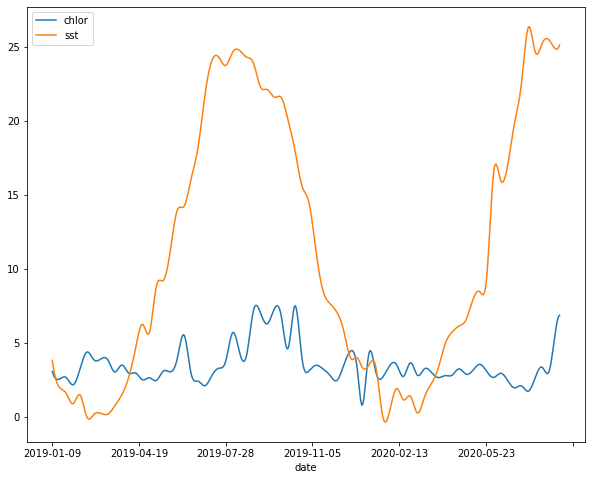

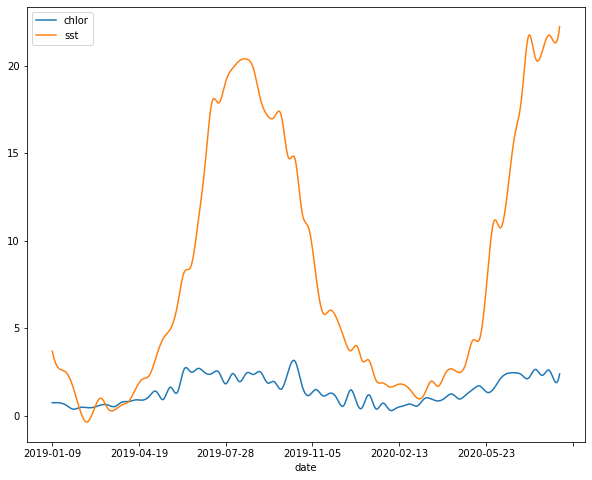

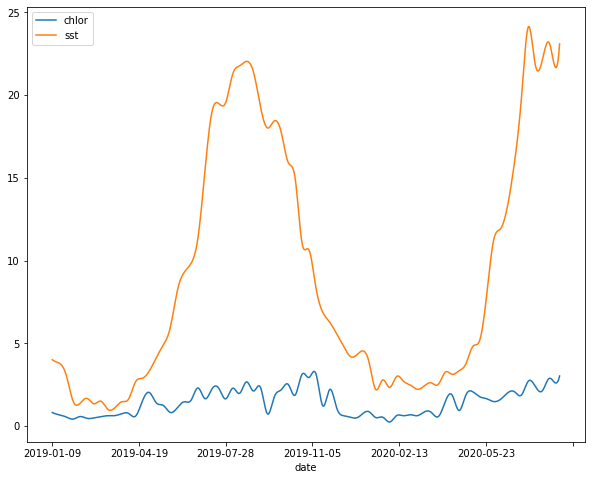

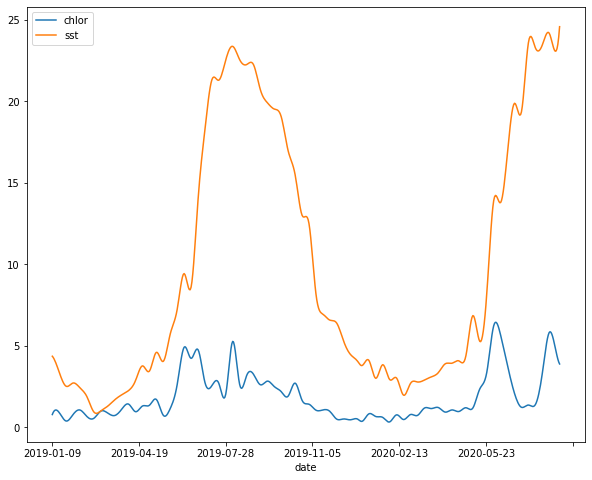

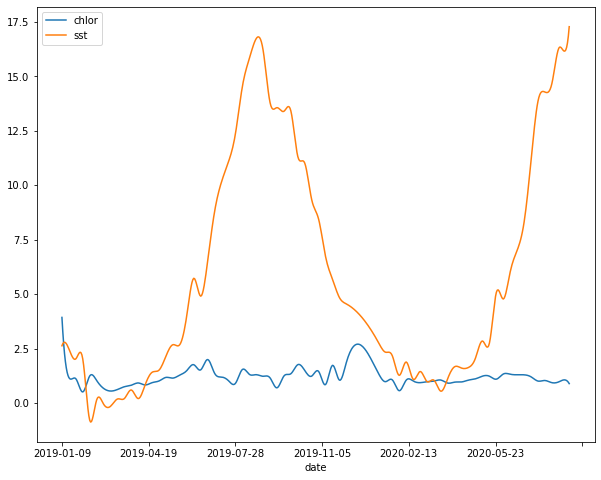

In [7]:
lake_df.set_index('date').groupby('lake')[['chlor','sst']].plot()

In [8]:
lake_df_final = lake_df[['date', 'chlor', 'sst', 'lake']].rename({'date':'ds', 'chlor':'y'}, axis='columns')

In [9]:
lake_df_final

,ds,y,sst,lake
0,2019-01-09,3.090394,3.833076,Erie
1,2019-01-10,2.908086,3.427211,Erie
2,2019-01-11,2.768572,3.084797,Erie
3,2019-01-12,2.667160,2.799866,Erie
4,2019-01-13,2.599154,2.566450,Erie
...,...,...,...,...
2925,2020-08-12,1.054696,16.204808,Superior
2926,2020-08-13,1.034493,16.325007,Superior
2927,2020-08-14,1.002084,16.531883,Superior
2928,2020-08-15,0.955819,16.842726,Superior


In [10]:
lakes = lake_df_final.groupby('lake')

In [11]:
target = pd.DataFrame()

Erie


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Huron


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Michigan


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Ontario


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Superior


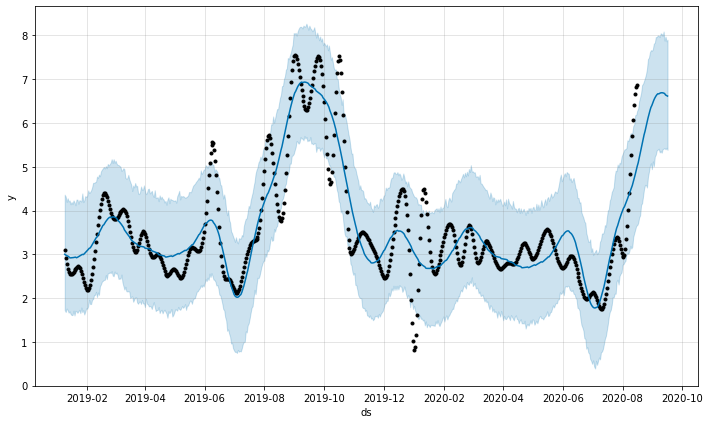

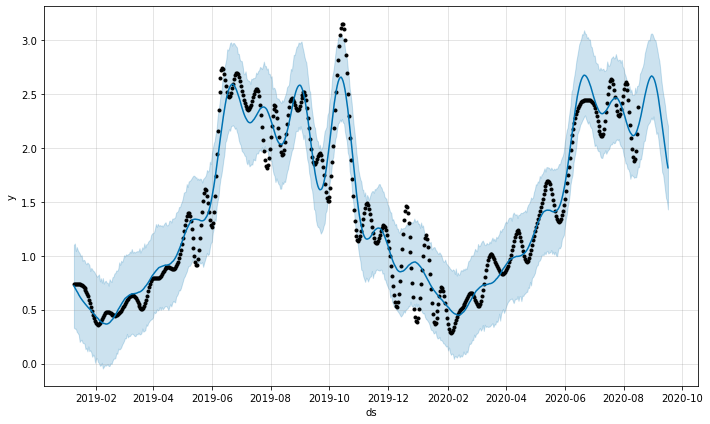

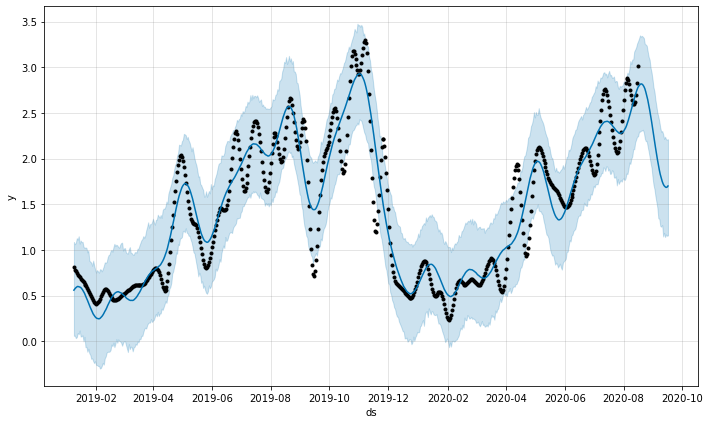

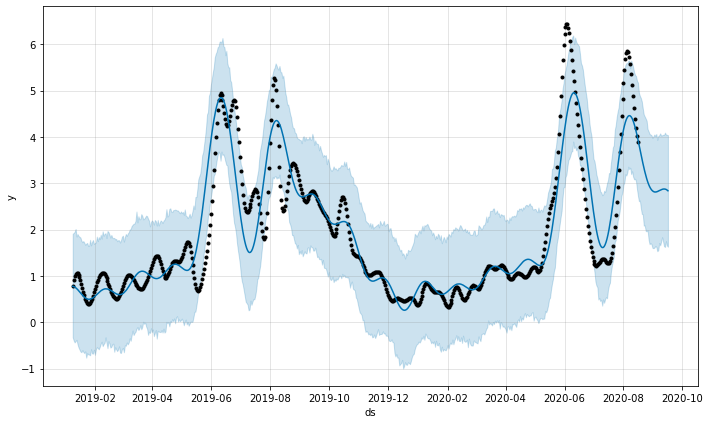

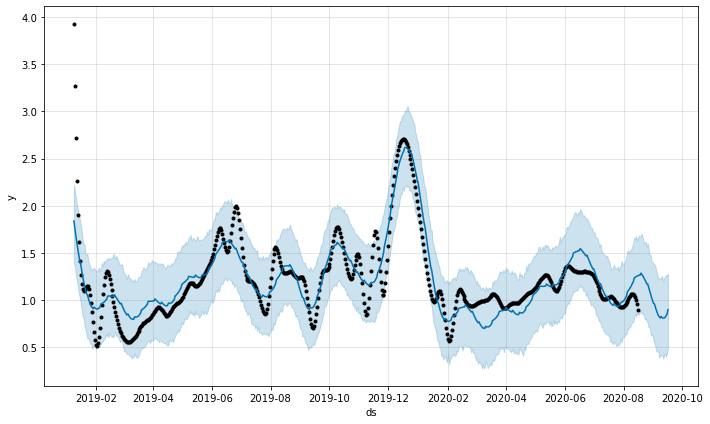

In [14]:
for lake in lakes.groups:
    print(lake)
    group = lakes.get_group(lake)
    model = Prophet(interval_width=0.95, changepoint_prior_scale = 0.01, yearly_seasonality=True)
    model.fit(group)
    future = model.make_future_dataframe(periods=31, freq = "d")
    forecast = model.predict(future)
    model.plot(forecast)
    forecast = forecast.rename(columns={'yhat':'chlor_'+lake})
    forecast.to_csv("forecast_"+lake+".csv")
    target = pd.merge(target, forecast.set_index('ds'), how='outer',
                    left_index=True, right_index=True)

In [15]:
target = target[['chlor_'+ lake for lake in lakes.groups.keys()]]

In [16]:
target.reset_index(inplace=True)
target.head()
#target["ds"]= target["ds"].datetime.strftime('%Y-%m-%d')

,ds,chlor_Erie,chlor_Huron,chlor_Michigan,chlor_Ontario,chlor_Superior
0,2019-01-09,2.999761,0.720942,0.560106,0.776967,1.838416
1,2019-01-10,2.982890,0.703753,0.574601,0.772267,1.760810
2,2019-01-11,2.969213,0.687134,0.586355,0.762268,1.685472
3,2019-01-12,2.957738,0.671586,0.595215,0.747809,1.612450
4,2019-01-13,2.948203,0.657398,0.601126,0.729649,1.542012


In [15]:
target['ds'] = target['ds'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [ ]:
target.dtypes

In [ ]:
target = target.set_index("ds")

In [ ]:
target.head()

In [ ]:
json = target.to_json()

In [37]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,chlor_Superior
0,2019-01-09,1.408821,1.420405,2.264041,1.408821,1.408821,0.429596,0.429596,0.429596,0.016050,0.016050,0.016050,0.413546,0.413546,0.413546,0.0,0.0,0.0,1.838416
1,2019-01-10,1.407735,1.379806,2.165603,1.407735,1.407735,0.353076,0.353076,0.353076,0.008093,0.008093,0.008093,0.344983,0.344983,0.344983,0.0,0.0,0.0,1.760810
2,2019-01-11,1.406649,1.287656,2.096499,1.406649,1.406649,0.278823,0.278823,0.278823,0.001615,0.001615,0.001615,0.277208,0.277208,0.277208,0.0,0.0,0.0,1.685472
3,2019-01-12,1.405563,1.207175,2.001423,1.405563,1.405563,0.206888,0.206888,0.206888,-0.003709,-0.003709,-0.003709,0.210597,0.210597,0.210597,0.0,0.0,0.0,1.612450
4,2019-01-13,1.404477,1.146382,1.980115,1.404477,1.404477,0.137535,0.137535,0.137535,-0.007977,-0.007977,-0.007977,0.145512,0.145512,0.145512,0.0,0.0,0.0,1.542012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,2020-09-12,1.193367,0.417455,1.210242,1.191379,1.195143,-0.384842,-0.384842,-0.384842,-0.003709,-0.003709,-0.003709,-0.381133,-0.381133,-0.381133,0.0,0.0,0.0,0.808525
613,2020-09-13,1.193073,0.403541,1.214046,1.190986,1.194928,-0.378212,-0.378212,-0.378212,-0.007977,-0.007977,-0.007977,-0.370235,-0.370235,-0.370235,0.0,0.0,0.0,0.814861
614,2020-09-14,1.192780,0.418587,1.238433,1.190606,1.194707,-0.360936,-0.360936,-0.360936,-0.006136,-0.006136,-0.006136,-0.354799,-0.354799,-0.354799,0.0,0.0,0.0,0.831844
615,2020-09-15,1.192486,0.477716,1.238277,1.190226,1.194489,-0.342958,-0.342958,-0.342958,-0.007935,-0.007935,-0.007935,-0.335024,-0.335024,-0.335024,0.0,0.0,0.0,0.849528


In [ ]:
json_file = open("chlor.json", "w")
n = json_file.write(json)
json_file.close()

In [ ]:
target

In [ ]:
geojson= [{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
        "name": "Tampa Bay",
        "ONE_MONTH": [{ x: DATETIME_UTC, y: 8 }, { x: DATETIME_UTC, y: 8 }],
"ONE_FORECAST": [{ x: DATETIME_UTC, y: 8 }, { x: DATETIME_UTC, y: 8 }],

        "confidenceInterval": 41.27,
        "seaSurfaceTemperature": 28.21,
        "chloroAForecast": 72.21 // last date of forecast
      },
      "geometry": {
        "type": "Point",
        "coordinates": [-82.49, 27.81]
      }
    },]

In [34]:
for i in range(len(target.tail(31))):

ds = target["ds"].tail(31).iloc[i]


In [35]:
target

,ds,chlor_Erie,chlor_Huron,chlor_Michigan,chlor_Ontario,chlor_Superior
0,2019-01-09,2.999761,0.720942,0.560106,0.776967,1.838416
1,2019-01-10,2.982890,0.703753,0.574601,0.772267,1.760810
2,2019-01-11,2.969213,0.687134,0.586355,0.762268,1.685472
3,2019-01-12,2.957738,0.671586,0.595215,0.747809,1.612450
4,2019-01-13,2.948203,0.657398,0.601126,0.729649,1.542012
...,...,...,...,...,...,...
612,2020-09-12,6.683494,2.061654,1.703709,2.876534,0.808525
613,2020-09-13,6.673390,1.995438,1.692721,2.874489,0.814861
614,2020-09-14,6.639601,1.928331,1.684835,2.868408,0.831844
615,2020-09-15,6.626583,1.868815,1.687526,2.856063,0.849528


In [17]:
target.to_csv("target.csv", index=False)